In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import json
from functools import reduce

In [2]:
directory = 'exp/json'
filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]

In [3]:
def is_valid_segment(line):
    segment = json.loads(line)
    return len(segment['speakers']) == 1 \
            and len(segment['ivectors']) == 1 \
            and len(segment['xvectors']) == 1 \
            # and segment['speakers'][0]['speaker_id'] in ['A', 'B']

def speakers_get_indexes(accumulator, speaker_tuple):
    speaker_id, index = speaker_tuple
    if speaker_id in accumulator:
        accumulator[speaker_id].append(index)
    else:
        accumulator[speaker_id] = [index]
    return accumulator

def segment_get_vectors(segment):
    return np.asarray(segment['ivectors'][0]['value']), np.asarray(segment['xvectors'][0]['value'])

filename = filenames[2] # <-------------------------------------------------- IMPORTANT
print(filename)
filepath = os.path.join(directory, filename)

# Getting the valid segments
file = open(filepath, 'r')
indexes = [index for index, line in enumerate(file.readlines()) if is_valid_segment(line)]
file.close()

# Getting the speakers segments indexes
file = open(filepath, 'r')
lines = file.readlines()
speakers_indexes = [(json.loads(lines[index])['speakers'][0]['speaker_id'], index) for index in indexes]
speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
file.close()

# Getting the speakers segments lengths
speakers_lengths = {}
for speaker_id in speakers_indexes:
    speakers_lengths[speaker_id] = len(speakers_indexes[speaker_id])

# Generating the speakers models
models_generation_length = 5 # <-------------------------------------------------- IMPORTANT
file = open(filepath, 'r')
lines = file.readlines()
speakers_models = {}
for speaker_id in speakers_indexes:
    speaker_indexes = speakers_indexes[speaker_id]
    speaker_ivectors, speaker_xvectors = zip(*[segment_get_vectors(json.loads(lines[index])) for index in speaker_indexes])
    _length = models_generation_length if models_generation_length < len(speaker_ivectors) else len(speaker_ivectors)
    speaker_ivector = np.sum(speaker_ivectors[:_length], 0) / _length
    _length = models_generation_length if models_generation_length < len(speaker_xvectors) else len(speaker_xvectors)
    speaker_xvector = np.sum(speaker_xvectors[:_length], 0) / _length
    speakers_models[speaker_id] = {}
    speakers_models[speaker_id]['ivectors'] = [speaker_ivector]
    speakers_models[speaker_id]['xvectors'] = [speaker_xvector]
file.close()

# Generating the model container permutations
models_container_length = 3 # <-------------------------------------------------- IMPORTANT
permutations = list(itertools.permutations(list(speakers_lengths.keys()) + ['0' for i in range(models_container_length)], models_container_length))
permutations = list(set(permutations))
permutations_map = []
permutations_length = 0
for index, permutation in enumerate(permutations):
    speaker_models_length = int(np.prod([len(speakers_models[speaker_id]['ivectors']) for speaker_id in permutation if speaker_id != '0']))
    permutations_map.append((permutations_length, permutations_length + speaker_models_length - 1, index))
    permutations_length += speaker_models_length
    
length = len(indexes) * permutations_length

recording = {}
recording['filepath'] = filepath
recording['length'] = length
recording['segments_indexes'] = indexes
recording['speakers_indexes'] = speakers_indexes
recording['speakers_lengths'] = speakers_lengths
recording['speakers_models'] = speakers_models
recording['permutations'] = permutations
recording['permutations_length'] = permutations_length
recording['permutations_map'] = permutations_map


iako.json


In [4]:
from torch.utils.data import Dataset, DataLoader, random_split

class Recording_dataset(Dataset):
    def __init__(self, recording, segments, mode = 'ivectors'):
        self.recording = recording
        self.segments = segments
        self.mode = mode
    def __len__(self):
        return self.recording['length']
    def __getitem__(self, idx):
        segment_idx, permutation_index = divmod(idx, self.recording['permutations_length'])
        segment_index = self.recording['segments_indexes'][segment_idx]
        
        segment = self.segments[segment_index]
        vector = np.asarray(segment[self.mode][0]['value'])
        
        permutation = self.recording['permutations'][permutation_index]
        
        models_container = [self.recording['speakers_models'][speaker_id][self.mode][0] if speaker_id != '0' else np.zeros(len(vector)) for speaker_id in permutation]
        
        x = np.concatenate([vector] + models_container)
        y = np.asarray([speaker_id == segment['speakers'][0]['speaker_id'] for speaker_id in permutation], dtype = float)
        
        return x, y


In [5]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU.')
else:
    device = torch.device('cpu')
    print('Running on the CPU.')

Running on the GPU.


In [6]:
file = open(filepath, 'r')
segments = [json.loads(line) for line in file.readlines()]
recording_dataset = Recording_dataset(recording, segments)
print(len(recording_dataset))

train_length = int(len(recording_dataset) * 0.7)
test_length = len(recording_dataset) - train_length
cross_length = int(train_length * 0.3)
train_length = train_length - cross_length

train_dataset, cross_dataset, test_dataset = random_split(recording_dataset, [train_length, cross_length, test_length])
train_dataloader = DataLoader(train_dataset, batch_size = 10, shuffle=True, num_workers = 4)
cross_dataloader = DataLoader(cross_dataset, batch_size = len(cross_dataset), num_workers = 4)

20075


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(4 * 128, 20)
        self.fc1 = nn.Linear(20, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 3)
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

<IPython.core.display.Javascript object>


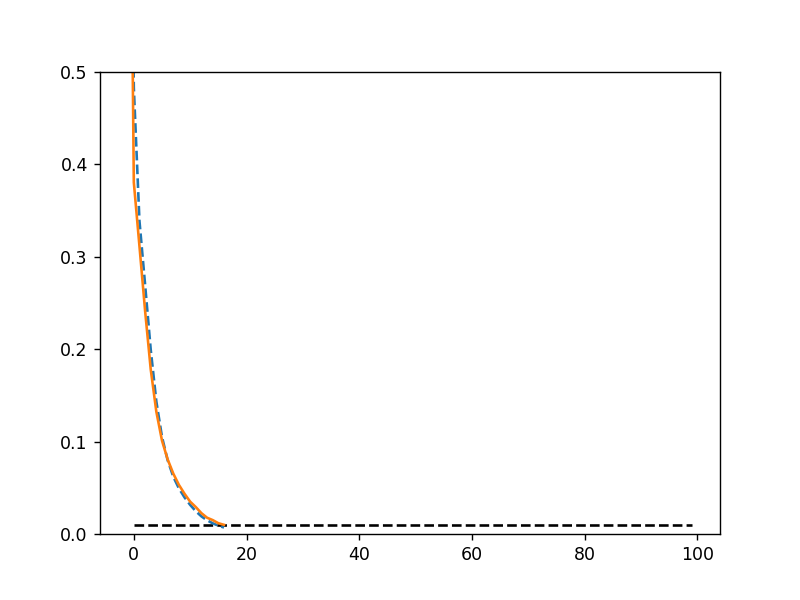

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Done training.


In [8]:
import torch.optim as optim

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0001)
criterion = nn.BCELoss()

epochs = 100
cross_loss_thr = 0.01

plt_thr = (np.linspace(0, epochs - 1, epochs), np.ones(epochs) * cross_loss_thr)
plt_loss = ([-1], [1])
plt_valid = ([-1], [1])

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim(0, 0.5)
line0, = ax.plot(plt_thr[0], plt_thr[1], 'k--')  # Threshold line
line1, = ax.plot(plt_loss[0], plt_loss[1], '--') # Training loss
line2, = ax.plot(plt_valid[0], plt_valid[1])     # Validation loss
fig.canvas.draw()
fig.canvas.flush_events()

for epoch in range(epochs):
    losses = []
    for input, target in train_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()

        net.zero_grad()

        output = net(input)

        loss = criterion(output, target)
        losses.append(loss.data)

        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for input, target in cross_dataloader:
            input = input.to(device, non_blocking=True).float()
            target = target.to(device, non_blocking=True).float()
            output = net(input)
            cross_loss = criterion(output, target)
            
    plt_loss[0].append(epoch)
    plt_loss[1].append(np.sum(losses) / len(losses))
    plt_valid[0].append(epoch)
    plt_valid[1].append(cross_loss.data)
    line1.set_xdata(plt_loss[0])
    line1.set_ydata(plt_loss[1])
    line2.set_xdata(plt_valid[0])
    line2.set_ydata(plt_valid[1])
    fig.canvas.draw()
    fig.canvas.flush_events()    
        
    # print('epoch:', epoch, 'loss:', loss, 'cross_loss:', cross_loss, end = '\r')
    
    if cross_loss < cross_loss_thr:
        print('Done training.')
        break

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), num_workers = 4)
with torch.no_grad():
    for input, target in test_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()
        output = net(input)
        test_loss = criterion(output, target)
    print('test_loss:', test_loss)

test_loss: tensor(0.0108, device='cuda:0')


In [10]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, num_workers = 1)
correct = 0
with torch.no_grad():
    for input, target in test_dataloader:
        input = input.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).float()
        output = net(input)
        if target.max(1)[1] == output.max(1)[1]:
            correct += 1
print(correct / len(test_dataset))

0.6827162543582932


In [11]:
file.close()